## Portfolio Optimization Using Modern Portfolio Theory

#### Description
This notebook utilizes OpenBB’s data for portfolio optimization based on MPT principles. We would be optimizing a portfolio of top 10 crypto assets, using the daily close data from 1st october 2023 to 1st october 2024.

The portfolio optimization would be done using the mean-variance approach. The mean-variance approach helps determine the optimal allocation of assets in a portfolio to minimize overall risk while maximizing expected returns.

#### Author
[Ambrose Ikpele](https://github.com/ambroseikpele)

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/OpenBB-Finance/OpenBB/blob/develop/examples/[Notebook_Name].ipynb)

Install external packages

In [ ]:
!pip install openbb
!pip install PyPortfolioOpt

Import necessary packages

In [1]:
from openbb import obb

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pypfopt import EfficientFrontier
from pypfopt import CovarianceShrinkage, CLA, expected_returns

Fetch the daily data of the top crypto currencies for a period of one year using openbb

In [2]:
top_crypto= ['ADA-USD', 'BNB-USD', 'BTC-USD', 'DOT-USD', 'ETH-USD', 'LTC-USD','MATIC-USD', 'SOL-USD', 'TRX-USD', 'XRP-USD']

ohlc_data= obb.crypto.price.historical(top_crypto, provider="yfinance", interval='1d', start_date='2023-10-01', end_date='2024-10-01').to_df()
ohlc_data

,open,high,low,close,volume,symbol
date,,,,,,
2023-10-01,0.254043,0.267471,0.254019,0.265895,1.650882e+08,ADA-USD
2023-10-01,214.800323,219.133835,213.506516,218.047134,3.874081e+08,BNB-USD
2023-10-01,26967.396484,28047.238281,26965.093750,27983.750000,9.503917e+09,BTC-USD
2023-10-01,4.105477,4.279937,4.103880,4.261009,8.294334e+07,DOT-USD
2023-10-01,1671.161499,1750.595703,1670.082153,1733.810425,5.054880e+09,ETH-USD
...,...,...,...,...,...,...
2024-10-01,66.820854,68.483223,66.786285,67.686295,2.475363e+08,LTC-USD
2024-10-01,0.395941,0.404462,0.394638,0.399719,3.507427e+07,MATIC-USD
2024-10-01,152.604584,157.199478,151.796982,155.045334,1.949461e+09,SOL-USD


Select the close data from ohlc_data for each crypto currency

In [3]:
close_symbol= ohlc_data[['close', 'symbol']]

# Setting the symbol as the second index level
close_symbol = close_symbol.set_index('symbol', append= True)

# Unstack 'symbol' to make each unique symbol a separate column
close_symbol_unstacked= close_symbol.unstack(level='symbol')

# Flatten the column headers
close_symbol_unstacked.columns = close_symbol_unstacked.columns.get_level_values(1)

prices= close_symbol_unstacked

prices

symbol,ADA-USD,BNB-USD,BTC-USD,DOT-USD,ETH-USD,LTC-USD,MATIC-USD,SOL-USD,TRX-USD,XRP-USD
date,,,,,,,,,,
2023-10-01,0.265895,218.047134,27983.750000,4.261009,1733.810425,68.233315,0.568532,23.836487,0.090118,0.524204
2023-10-02,0.259513,214.757935,27530.785156,4.123762,1663.627563,66.011124,0.547513,23.371700,0.087566,0.512832
2023-10-03,0.261028,213.435944,27429.978516,4.074247,1656.685669,65.493515,0.566308,23.552694,0.090858,0.538387
2023-10-04,0.259315,213.413086,27799.394531,4.047316,1647.838135,64.452065,0.563369,23.144787,0.088999,0.532931
2023-10-05,0.260149,210.679672,27415.912109,4.022738,1611.476440,64.858765,0.546018,22.694141,0.088276,0.523366
...,...,...,...,...,...,...,...,...,...,...
2024-09-27,0.402328,607.867004,65790.664062,4.892055,2695.900635,71.188202,0.433774,157.749939,0.155170,0.588927
2024-09-28,0.401052,601.567200,65887.648438,4.805896,2677.539062,70.003967,0.423559,156.912430,0.155068,0.614801
2024-09-29,0.397597,596.411194,65635.304688,4.768428,2659.346924,69.314423,0.421419,158.629166,0.156474,0.641947


calculate the expected returns of each asset and covariance matrix of crypto assets

In [4]:
# Expected returns of crypto assets using the mean historical return.
portfolio_expected_returns = expected_returns.mean_historical_return(prices, frequency=365, compounding=False)

# Covariance matrix of crypto assets using the Ledoit-Wolf shrinkage method.
covariance = CovarianceShrinkage(prices).ledoit_wolf()

In [5]:
portfolio_expected_returns

,0
symbol,
ADA-USD,0.621306
BNB-USD,1.130899
BTC-USD,0.950751
DOT-USD,0.324462
ETH-USD,0.592597
LTC-USD,0.186095
MATIC-USD,-0.048860
SOL-USD,2.297820
TRX-USD,0.619805


In [6]:
covariance

symbol,ADA-USD,BNB-USD,BTC-USD,DOT-USD,ETH-USD,LTC-USD,MATIC-USD,SOL-USD,TRX-USD,XRP-USD
symbol,,,,,,,,,,
ADA-USD,0.365908,0.149985,0.179671,0.303813,0.203350,0.204707,0.278248,0.296429,0.083626,0.194114
BNB-USD,0.149985,0.230834,0.122378,0.150464,0.138874,0.108916,0.173514,0.171700,0.046899,0.093489
BTC-USD,0.179671,0.122378,0.189577,0.175989,0.172308,0.127100,0.170163,0.221531,0.054940,0.120379
DOT-USD,0.303813,0.150464,0.175989,0.385419,0.206734,0.192864,0.287835,0.333077,0.085921,0.192047
ETH-USD,0.203350,0.138874,0.172308,0.206734,0.259265,0.160001,0.224481,0.232270,0.063282,0.133110
LTC-USD,0.204707,0.108916,0.127100,0.192864,0.160001,0.270176,0.190943,0.191517,0.055659,0.158148
MATIC-USD,0.278248,0.173514,0.170163,0.287835,0.224481,0.190943,0.414685,0.290214,0.075435,0.180736
SOL-USD,0.296429,0.171700,0.221531,0.333077,0.232270,0.191517,0.290214,0.593740,0.095372,0.184846
TRX-USD,0.083626,0.046899,0.054940,0.085921,0.063282,0.055659,0.075435,0.095372,0.098433,0.057513


Calculate the efficient frontier using the Critical Line Algorithm

In [7]:
# Create a Critical Line Algorithm (CLA) object using the calculated expected returns and covariance matrix.
cla = CLA(portfolio_expected_returns, covariance)

# Calculate the efficient frontier, obtaining the returns, volatility, and weights for various portfolios.
(returns, volatility, weights) = cla.efficient_frontier()

Visualize the efficient frontier

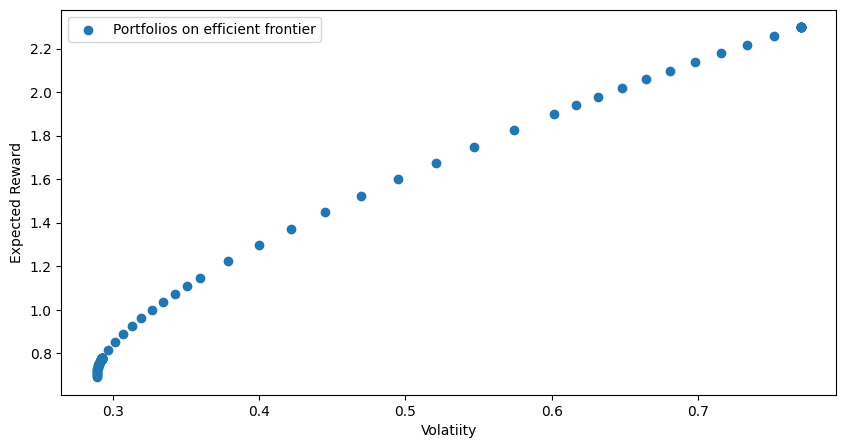

In [8]:
plt.figure(figsize=(10,5))
plt.scatter(volatility, returns, label='Portfolios on efficient frontier')
plt.legend()
plt.ylabel('Expected Reward')
plt.xlabel('Volatiity')
plt.show()

Get the weights (in perentage) of the portfolio with the lowest volatility

In [9]:

optimized_weight=weights[volatility.index(min(volatility))]
pie_df=pd.DataFrame(optimized_weight*100, index=prices.columns, columns=['weights'])
pie_df= pie_df.sort_values(by=['weights'], ascending=False)
pie_df

,weights
symbol,
TRX-USD,67.715856
BNB-USD,13.161715
BTC-USD,9.982129
XRP-USD,5.275661
LTC-USD,3.864639
ADA-USD,0.000000
DOT-USD,0.000000
ETH-USD,0.000000
MATIC-USD,0.000000


Display Pie Chart of the weights

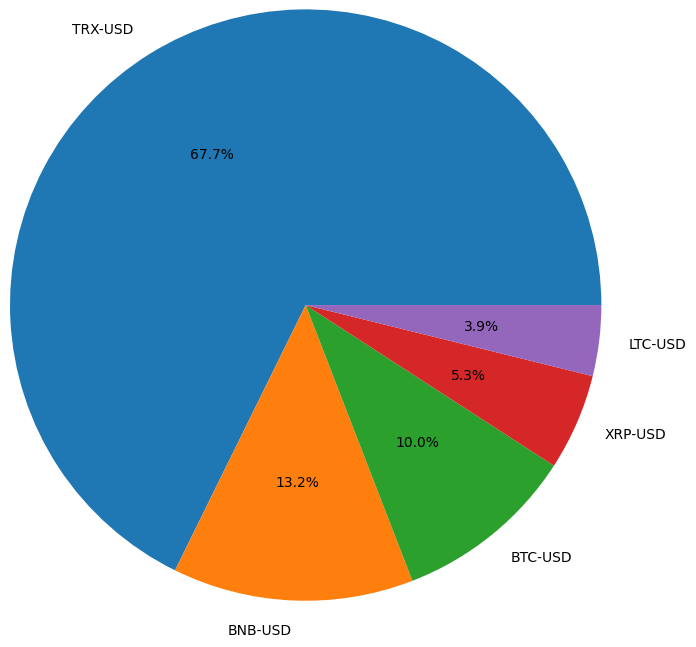

In [10]:
pie_df= pie_df.query('weights != 0.000000')

fig, ax = plt.subplots()
ax.pie(pie_df.weights, labels=pie_df.index.values.tolist(), autopct='%1.1f%%', radius=2)
plt.show()